<a href="https://colab.research.google.com/github/majidraeis/MultiStage/blob/master/MultiStageQueue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Generation for Multi-stage Tandem Queues


![MutiServer](https://drive.google.com/open?id=1dHNXJby--LD201bE8ymGo3S2N7uBNzp2)


In [0]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import csv, copy
from tqdm import tqdm
import os
# import nested_dict as nd

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Single-Stage Multi-server Queue as a Building Block


In [0]:
class Job:
    def __init__(self, Ta, Ts, index):
        length = np.size(Ta)
        Td = np.zeros(length)
        Tw = np.zeros(length)
        Ba = np.zeros(length)
        Dict = {}
        for i in range(len(Ta)):
            Dict[index[i]]= {'Ta':Ta[i], 'Td':Td[i], 'Ts':Ts[i], 'Tw':Tw[i], 'Ba':Ba[i]}
        
        self.dict = Dict
#         self.dict = dict(zip(index, np.hstack((Ta, Td, Ts, Tw, Ba))))
        # Dictionary values:  1-ArrivalTime 2-DepartureTime 3-ServiceTime 4-WaitingTime 5-BackloggUponArrival 
def MultiServQueue(job, N):
    jobMatrix = np.array(job.dict.values())
    jobIndex = np.array(job.dict.keys())
    length = len(jobIndex)
    order = np.argsort(np.array([f['Ta'] for f in jobMatrix]).flatten())
    Ta = np.array([f['Ta'] for f in jobMatrix])[order]
    Ts = np.array([f['Ts'] for f in jobMatrix])[order]
    jobIndexOrdered = jobIndex[order]
    indexout = []
    f = Ta[0:N] + Ts[0:N]
    les_f = Ta[0:N]
    d = sorted(f)
    e = sorted(les_f)
    index = jobIndexOrdered[np.argsort(f)]
    backlogD = [[0, 0, 0]]
    backlogA = []
    jobDepCum = []
    jobEsCum = []

    for i in tqdm(range(0, length)):
        JobDep, d = d[0], np.delete(d, 0)
        Es, e = e[0], np.delete(e, 0)
        indexout = np.append(indexout, index[0])
        index = np.delete(index, 0)

        jobDepCum.append(JobDep)
        jobEsCum.append(Es)

        tempOcc = float(np.sum(Ta <= JobDep) - (i + 1))
        backlogD.append([JobDep, max(tempOcc - N, 0.0), tempOcc])
        tempOcc = float(i + 1 - np.sum(jobDepCum <= Ta[i]))
        backlogA.append([Ta[i], max(tempOcc - N, 0.0), tempOcc])
        job.dict[jobIndex[i]]['Ba'] = np.round(max(i - np.sum(jobDepCum <= Ta[i]), 0))
        # num of customors in the system (including servers) right upon i'th arrival

        if i <= length - N - 1:
            F = max(Ta[N + i], JobDep) + Ts[N + i]
            u = np.append(F, d)
            u = np.maximum(u, F)
            addedIndex = np.sum(u == F) - 1
            d = np.minimum(np.append(d, np.inf), u)
            index = np.append(index[:addedIndex], np.append(jobIndexOrdered[N + i], index[addedIndex:]))
            e = np.append(e, max(Ta[N + i], JobDep))

        job.dict[indexout[-1]]['Td'] = JobDep
#         job.dict[indexout[-1]][3]= max(0 , JobDep - job.dict[indexout[-1]][0]) # delay (Sojourn)
        job.dict[indexout[-1]]['Tw'] = max(0.0, JobDep - job.dict[indexout[-1]]['Ta'] - job.dict[indexout[-1]]['Ts'])  # waiting

    jobEsCum = np.array(jobEsCum)

    backlogA = np.concatenate((backlogA, backlogD))
    backlogA = np.array(sorted(backlogA, key=lambda x: x[0]))
    job.b = backlogA
    job.index = indexout.astype(int)

## Defining Different Arrival Processes


In [0]:
def MarkovOnOff(length, Alpha, Beta, Lambda):  # Alpha = off-> on | Beta = on -> off
    s = 1
    interArr = np.zeros(length)
    i = 0
    while i < length:

        state_stay = np.random.exponential(1 / Beta)
        elapsed_time = 0
        while s and i < length:
            temp = np.random.exponential(1/Lambda)
            elapsed_time = elapsed_time + temp
            if elapsed_time < state_stay:
                interArr[i] = interArr[i] + temp
                i += 1
            else:
                interArr[i] = interArr[i] + state_stay - (elapsed_time - temp)
                s = 0
        if not s and i < length:
            state_stay = np.random.exponential(1 / Alpha)
            interArr[i] = interArr[i] + state_stay
            s = 1
    Ta = np.cumsum(interArr)
    return Ta


def DetOnOff(length, Ton, Toff, Ta_ON):
    Num_ON = int(Ton/Ta_ON)
    Num_OFF = int(Toff/Ta_ON)
    inter_arr = []
    i = 0
    while i < length-Num_ON:
            inter_arr = np.append(inter_arr, Ta_ON * np.ones(Num_ON-1))
            inter_arr = np.append(inter_arr, Ta_ON * Num_OFF)
            i += Num_ON
    inter_arr = np.append(inter_arr, Ta_ON * np.ones(length-i))
    Ta = np.cumsum(inter_arr)
    return Ta

def DetVarRate(length, t_on1, t_on2, t_a1, t_a2):
    Num_ON1 = int(t_on1/t_a1)
    Num_ON2 = int(t_on2/t_a2)
    inter_arr = []
    i = 0
    while i < length-Num_ON1-Num_ON2:
            inter_arr = np.append(inter_arr, t_a1 * np.ones(Num_ON1))
            inter_arr = np.append(inter_arr, t_a2 * np.ones(Num_ON2))
            i += Num_ON1+Num_ON2
    if length-i > Num_ON1:
        inter_arr = np.append(inter_arr, t_a1 * np.ones(Num_ON1))
        inter_arr = np.append(inter_arr, t_a2 * np.ones(length-i-Num_ON1))
    else:
        inter_arr = np.append(inter_arr, t_a1 * np.ones(length - i))
    Ta = np.cumsum(inter_arr)
    return Ta


def NonHomPoisson(length, Lambda, lambda_u):
    Ta = []
    t = 0
    l = 0
    while l < length:
        t = t + np.random.exponential(1/lambda_u)
        if np.random.uniform(0, 1) < Lambda(t)/lambda_u:
            Ta.append(t)
            l += 1
    Ta = np.array(Ta)
    return Ta

## Initialization

In [0]:
#@title Choose Arrival and Service Processes { run: "auto" }

ArrivalType = 'NonHomPoisson' #@param ["'M'", "'H2'", "'M_ONOFF'", "'DetOnOff'", "'NonHomPoisson'", "'MarkovOnOff'"] {type:"raw"}
ServiceType = 'logNorm' #@param ["'M'", "'logNorm'"] {type:"raw"}


In [0]:
#@title Number of Stages { run: "auto", display-mode: "form" }

stageNum = 10 #@param {type:"slider", min:0, max:100, step:1}

In [0]:
#@title Training or Testing { run: "auto" }
training = True #@param {type:"boolean"}

In [0]:
# training = 0 # set to one(zero) for generating training(test) data
rho = 0.95
TotHistLength = 5
N = stageNum*[3]
mean_Ts = 1*np.ones(stageNum)
mean_Ta = mean_Ts[0] / (N[0] * rho)
day = 24*12
# time_step = 24*60.0/day # Time unit (mins)
if training:
    duration = 20 * day
else:
    duration = 10 * day
lengthTa = int(duration / mean_Ta)
train_length = int(20 * day / mean_Ta)
samplePathLen = int(5 * day / mean_Ta)
test_length = int(10 * day / mean_Ta) 
c_a = 2.0

gdrive_dir = '/content/gdrive/My Drive/Colab Notebooks'
data_directory = gdrive_dir + '/MultiStage/%s_%s' % (ArrivalType, ServiceType)
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

## Defining Arrival and Service Generating Functions

In [0]:
def Arrival_Gen(ArrivalType, mean_Ta, lengthTa):
    if ArrivalType == "M":
        interArr = np.random.exponential(mean_Ta, lengthTa)
        Ta = np.cumsum(interArr)

    elif ArrivalType == "H2":
        c_a = 2.0 #SCV
        p1 = 0.5*(1+((c_a**2-1)/(c_a**2+1))**0.5)
        p2 = 1-p1
        mu1 = 2*p1/mean_Ta
        mu2 = 2*p2/mean_Ta
        coeff1 = (np.random.uniform(0, 1, lengthTa) < p1)
        coeff2 = ~ coeff1
        interArr1 = np.random.exponential(1/mu1, lengthTa)
        interArr2 = np.random.exponential(1 / mu2, lengthTa)
        interArr = coeff1*interArr1 + coeff2*interArr2
        Ta = np.cumsum(interArr)

    elif ArrivalType == "M_ONOFF":
        Alpha = 0.01
        Beta = 0.1
        Lambda = N*rho*(Alpha + Beta)/(Alpha * mean_Ts)
        Ta = MarkovOnOff(lengthTa, Alpha, Beta, Lambda)
    elif ArrivalType == "DetOnOff":
        T_period = day #/ 24.0  # i.e. E[s] = 5min
        ON_ratio = 0.75
        T_on = ON_ratio * T_period
        T_off = T_period - T_on
        Ta_on = mean_Ta * ON_ratio # (mean_Ts/(N*rho)) * ON_ratio
        Ta = DetOnOff(lengthTa, T_on, T_off, Ta_on)
    elif ArrivalType == "DetVarRate":
        t_on1, t_on2 = 10.0, 10.0
        t_a1, t_a2 = .1, 1
        Ta = DetVarRate(lengthTa, t_on1, t_on2, t_a1, t_a2)
    elif ArrivalType == 'NonHomPoisson':
        alpha = 0.5 #relative amplitude
        lambda_bar = 1 / mean_Ta
        lambda_u = lambda_bar * (1 + alpha)
        Gamma = day#cycle life
        Lambda = lambda t: lambda_bar + lambda_bar * alpha * np.sin(2*np.pi*t/Gamma)
        Ta = NonHomPoisson(lengthTa, Lambda, lambda_u)
    return Ta

def Service_Gen(ServiceType, mean_Ts, lengthTa):
    Ts = []
    if ServiceType == "M": #exponential
        Ts = np.random.exponential(mean_Ts, lengthTa)

    elif ServiceType == "logNorm":  # for lognormal service
        c_s = 1.0 #SCV
        sigma = np.log(1+c_s**2)**0.5
        mu = np.log(mean_Ts) - (sigma**2)/2.0
        Ts = np.exp(np.random.normal(mu, sigma, lengthTa))
    return Ts

## Running Simulations with the Generated Processes

100%|██████████| 8208/8208 [00:06<00:00, 1254.84it/s]


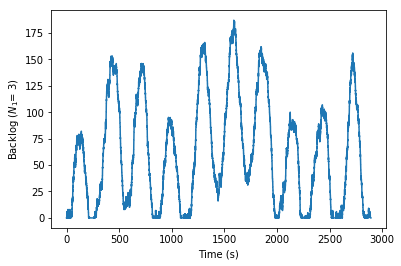

100%|██████████| 8208/8208 [00:06<00:00, 1252.49it/s]


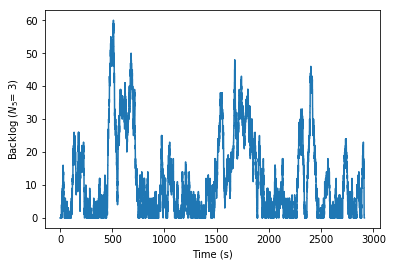

100%|██████████| 8208/8208 [00:07<00:00, 1074.37it/s]


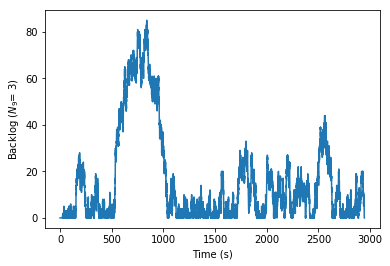

100%|██████████| 8208/8208 [00:06<00:00, 1240.16it/s]


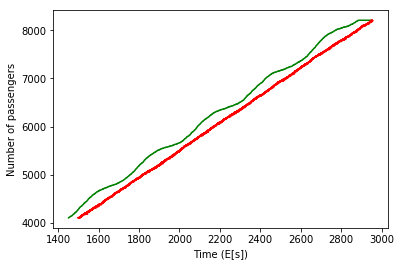

In [0]:
Ta = Arrival_Gen(ArrivalType, mean_Ta, lengthTa)
Ts = Service_Gen(ServiceType, mean_Ts[0], lengthTa)
job = Job(Ta, Ts, np.arange(1, lengthTa + 1))

for stage in range(stageNum):
    
    MultiServQueue(job, N[stage])
    jobMatrix = np.array(job.dict.values())
    jobIndex = np.array(job.dict.keys())
    if stage > 0: 
        assert np.sum(jobIndex-jobIndexOld)==0,"The order of the jobs are not transfered correctly"
    jobIndexOld = copy.copy(jobIndex)

    arrival_time = np.array([f['Ta'] for f in jobMatrix])
    service_time = np.array([f['Ts'] for f in jobMatrix])
    waiting_time = np.array([f['Tw'] for f in jobMatrix])
    departure_time = np.array([f['Td'] for f in jobMatrix])
    
    if stage%(int((stageNum-1)/2))==0:
        plt.figure()
        plt.step(*zip(*job.b[:,:2]), where='post')
        plt.ylabel('Backlog ($N_{%s}$= %s)'%(stage+1, N[stage]))
        plt.xlabel('Time (s)')
        plt.show()

    if stage==0:
        totalJobMatrix = np.hstack((arrival_time.reshape(-1,1), departure_time.reshape(-1,1),
                                    waiting_time.reshape(-1,1)))
        e2eDelay = waiting_time + service_time
    else:
        totalJobMatrix = np.hstack((totalJobMatrix, departure_time.reshape(-1,1),
                                    waiting_time.reshape(-1,1)))
        e2eDelay = e2eDelay + waiting_time + service_time
    
   # -----------creating job matrix for the next stage----------------------
    if stage+1 < stageNum:
        Ts = Service_Gen(ServiceType, mean_Ts[stage+1], lengthTa)
        for i in range(len(arrival_time)):
            job.dict[i+1]= {'Ta':departure_time[i], 'Td':0.0, 'Ts':Ts[i], 'Tw':0.0, 'Ba':0.0}
    
X = np.append(np.append(0, totalJobMatrix[:,0]), departure_time[-1])
Y = np.append(range(0, lengthTa + 1), lengthTa)
plt.step(X[-samplePathLen:], Y[-samplePathLen:], 'g', where='post', label='Cumalative arrival')
X = np.append(0, departure_time)
Y = range(0, lengthTa + 1)
plt.step(X[-samplePathLen:], Y[-samplePathLen:], 'r', where='post', label='Cumulative departure')
plt.ylabel('Number of customers')
plt.xlabel('Time (E[s])')
plt.show()    

label = np.reshape(e2eDelay,(-1, 1))


## Dataset Preperation & Saving Data

We use LCS (Last Customer to complete Service) features in each stage as delay history.



In [0]:
order = np.argsort(totalJobMatrix[:, 0])
totalJobMatrix = totalJobMatrix[order]
label = label[order]

History = []
Tot_LCS = []
for i in range(lengthTa):
    ta = totalJobMatrix[i, 0]
    for stage in range(stageNum):
#         ------Finding LCS in each stage --------------
        departure_time = copy.copy(totalJobMatrix[:, 2*stage+1])
        departure_time[departure_time > ta] = np.inf
        index = np.argsort(abs(departure_time-ta))[:TotHistLength]
#         ----------------------------------------------
        if np.prod(departure_time[index] < np.inf):
            History.append(totalJobMatrix[:, 2*stage+2][index])
        else:
            History = []
            Tot_LCS = []
            begin = i
            break
#   ------Finding LCS in Tandem Queue --------------
    departure_time = copy.copy(totalJobMatrix[:, 2*stageNum-1])
    departure_time[departure_time > ta] = np.inf
    index = np.argsort(abs(departure_time-ta))[:TotHistLength]
    if np.prod(departure_time[index] < np.inf):
        Tot_LCS.append(label[index])
#   ----------------------------------------------
Tot_LCS = np.reshape(Tot_LCS, (-1, TotHistLength)) 
History = np.reshape(History, (-1, TotHistLength*stageNum)) 
# Dataset Generation
data = totalJobMatrix[begin+1:, 0].reshape(-1, 1) #Arrival Times
for stage in range(stageNum):
    data = np.hstack((data, History[:, stage*TotHistLength:(stage+1)*TotHistLength]))
data = np.hstack((data, label[begin+1:], Tot_LCS))

# ----------------------WRITING DATA----------------------
if training:
    with open(data_directory+'/DelayPredTrainingdata.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(data)
    csvFile.close()
else:
    with open(data_directory+'/DelayPredTestdata.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(data)
    csvFile.close()
    with open(data_directory+'/samplePath.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(data[-samplePathLen:, :])
    csvFile.close()


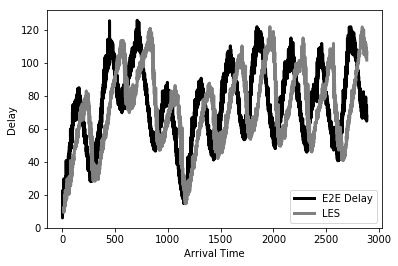

In [0]:
fig = plt.figure()
plt.plot(Ta, label, c='k', lw=3.0, label='E2E Delay')
plt.plot(Ta[begin+1:], Tot_LCS[:, 0], c='0.5', lw=3.0, label='LES')
plt.legend()
plt.xlabel('Arrival Time')
plt.ylabel('Delay')
plt.show()

In [0]:
# import pandas as pd
# Dataset = pd.DataFrame(
# {
#     'Arrival Time' : totalJobMatrix[begin+1:, 0],
#     'History': list(History[:, :2])
# }
# )
# Dataset


##Defining Some Useful Functions

In [0]:
import numpy as np
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Dense
from keras.engine.topology import Layer
import tensorflow as tf
from tensorflow.contrib.distributions import Categorical, Mixture, MultivariateNormalDiag
from keras.callbacks import Callback, EarlyStopping
from keras.models import Sequential
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, gaussian_kde
from matplotlib import cm
from scipy.optimize import minimize, minimize_scalar

"""
A Mixture Density Layer for Keras
cpmpercussion: Charles Martin (University of Oslo) 2018
https://github.com/cpmpercussion/keras-mdn-layer
Hat tip to [Omimo's Keras MDN layer](https://github.com/omimo/Keras-MDN) for a starting point for this code.
"""
def elu_plus_one_plus_epsilon(x):
    """ELU activation with a very small addition to help prevent NaN in loss."""
    return (K.elu(x) + 1 + 1e-8)


class MDN(Layer):
    """A Mixture Density Network Layer for Keras.
    This layer has a few tricks to avoid NaNs in the loss function when training:
        - Activation for variances is ELU + 1 + 1e-8 (to avoid very small values)
        - Mixture weights (pi) are trained in as logits, not in the softmax space.
    A loss function needs to be constructed with the same output dimension and number of mixtures.
    A sampling function is also provided to sample from distribution parametrised by the MDN outputs.
    """

    def __init__(self, output_dimension, num_mixtures, **kwargs):
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        with tf.name_scope('MDN'):
            self.mdn_mus = Dense(self.num_mix * self.output_dim, name='mdn_mus')  # mix*output vals, no activation
            self.mdn_sigmas = Dense(self.num_mix * self.output_dim, activation=elu_plus_one_plus_epsilon, name='mdn_sigmas', activity_regularizer=regularizers.l2(0.05))  # mix*output vals exp activation
            self.mdn_pi = Dense(self.num_mix, name='mdn_pi')  # mix vals, logits
        super(MDN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        self.trainable_weights = self.mdn_mus.trainable_weights + self.mdn_sigmas.trainable_weights + self.mdn_pi.trainable_weights
        self.non_trainable_weights = self.mdn_mus.non_trainable_weights + self.mdn_sigmas.non_trainable_weights + self.mdn_pi.non_trainable_weights
        super(MDN, self).build(input_shape)

    def call(self, x, mask=None):
        with tf.name_scope('MDN'):
            mdn_out = keras.layers.concatenate([self.mdn_mus(x),
                                                self.mdn_sigmas(x),
                                                self.mdn_pi(x)],
                                               name='mdn_outputs')
        return mdn_out

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {
            "output_dimension": self.output_dim,
            "num_mixtures": self.num_mix
        }
        base_config = super(MDN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def get_mixture_loss_func(output_dim, num_mixes):
    """Construct a loss functions for the MDN layer parametrised by number of mixtures."""
    # Construct a loss function with the right number of mixtures and outputs
    def loss_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss

    # Actually return the loss_func
    with tf.name_scope('MDN'):
        return loss_func


def get_mixture_sampling_fun(output_dim, num_mixes):
    """Construct a sampling function for the MDN layer parametrised by mixtures and output dimension."""
    # Construct a loss function with the right number of mixtures and outputs
    def sampling_func(y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        # Todo: temperature adjustment for sampling function.
        return samp

    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return sampling_func


def get_mixture_mse_accuracy(output_dim, num_mixes):
    """Construct an MSE accuracy function for the MDN layer
    that takes one sample and compares to the true value."""
    # Construct a loss function with the right number of mixtures and outputs
    def mse_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        mse = tf.reduce_mean(tf.square(samp - y_true), axis=-1)
        # Todo: temperature adjustment for sampling functon.
        return mse

    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return mse_func


def split_mixture_params(params, output_dim, num_mixes):
    """Splits up an array of mixture parameters into mus, sigmas, and pis
    depending on the number of mixtures and output dimension."""
    mus = params[:num_mixes*output_dim]
    sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits


def softmax(w, t=1.0):
    """Softmax function for a list or numpy array of logits. Also adjusts temperature."""
    e = np.array(w) / t  # adjust temperature
    e -= np.max(e, axis=1, keepdims=1)  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e, axis=1, keepdims=1)
    return dist


def sample_from_categorical(dist):
    """Samples from a categorical model PDF."""
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    tf.logging.info('Error sampling mixture model.')
    return -1


def sample_from_output(params, output_dim, num_mixes, length=1):
    """Sample from an MDN output with temperature adjustment."""
    mus = params[:, :num_mixes*output_dim]
    sigs = params[:, num_mixes*output_dim:2*num_mixes*output_dim]
    pis = softmax(params[:, -num_mixes:])
    m = sample_from_categorical(pis.reshape(-1,1))
    sample = np.random.normal(mus[0, m*output_dim:(m+1)*output_dim], sigs[0, m*output_dim:(m+1)*output_dim], size=length)
    return sample

    # //////////////////////////////////////////////////////////////////////////////////////////
def mixture_density(params, output_dim, num_mixes):
    mus = params[:num_mixes * output_dim]
    sigs = params[num_mixes * output_dim:2 * num_mixes * output_dim]
    pis = softmax(params[-num_mixes:])
    range_plot = np.linspace(min(mus-3*sigs), max(mus+3*sigs), 100)
    pdf = np.zeros(len(range_plot))
    for i in range(num_mixes):
        pdf = pdf+pis[i]* norm.pdf(range_plot, mus[i], sigs[i])
    predicted_delay = sum(mus*pis)
    return range_plot, pdf, predicted_delay

def mixture_CDF(quantile, params, output_dim, num_mixes):
    mus = params[:, :num_mixes * output_dim].reshape(-1, 1)
    sigs = params[:, num_mixes * output_dim:2 * num_mixes * output_dim].reshape(-1, 1)
    pis = softmax(params[:, -num_mixes:]).reshape(-1, 1)
    cdf = 0
    for j in range(num_mixes):
        cdf = cdf + pis[j] * norm.cdf(quantile, mus[j], sigs[j])
    return cdf


def conditional_mean(rho, w, N): #conditional average delay for M/M/1 Queue
    return rho * w + 2/N

def conditional_std(rho, w, N): #conditional variance delay for M/M/1 Queue
    return (2*rho * w/N + 2/(N**2))**0.5

def data_gen_dist_based(SampleNum, Wrange, N, mean_Ta, mean_Ts, ArrivalType='M', ServiceType='M'): # w=LES delay
    if ArrivalType == 'M' and ServiceType == 'M':
        A = np.random.poisson(tuple(Wrange/mean_Ta), (SampleNum, len(Wrange)))
        delay_w_matrix = np.random.gamma(tuple((A+2).flatten()), 1.0*mean_Ts/N).reshape(SampleNum, len(Wrange))
        dataset = np.zeros((1, 2))
    elif ArrivalType == 'H2' and ServiceType == 'M':
        A = np.zeros((SampleNum, 1))
        for i, w in enumerate(Wrange):
            A = np.append(A, HOL_based_delay_gen(ArrivalType, ServiceType, w, mean_Ta, mean_Ts, SampleNum, N).reshape(-1, 1), axis=1)
        A = A[:, 1:]
        delay_w_matrix = np.random.gamma(tuple((A + 2).flatten()), 1.0 * mean_Ts / N).reshape(SampleNum, len(Wrange))
        dataset = np.zeros((1, 2))

    for i in range(len(Wrange)):
        temp = np.append(Wrange[i] * np.ones((SampleNum, 1)), delay_w_matrix[:, i].reshape(-1, 1), axis=1)
        dataset = np.append(dataset, temp, axis=0)

    return dataset[1:]


def CCDF_CHRNF_BOUND(theta, W, th, mu, lam):
    return np.exp(lam*W*(theta / (mu-theta)) - th*theta) * (mu/(mu-theta))**2


def HOL_based_delay_gen(ArrivalType, ServiceType, w_hol, mean_Ta, mean_Ts, sample_num, N):

    if ArrivalType == "M":
        A = np.random.poisson(w_hol/mean_Ta, sample_num)
    elif ArrivalType == "H2":
        c_a = 2.0 #SCV
        p1 = 0.5*(1+((c_a**2-1)/(c_a**2+1))**0.5)
        p2 = 1-p1
        mu1 = 2*p1/mean_Ta
        mu2 = 2*p2/mean_Ta
        A = np.zeros(sample_num)
        for i in range(sample_num):
            time = 0
            while(time < w_hol):
                coeff1 = np.random.uniform(0, 1) < p1
                coeff2 = not coeff1
                interArr1 = np.random.exponential(1 / mu1)
                interArr2 = np.random.exponential(1 / mu2)
                interArr = coeff1 * interArr1 + coeff2 * interArr2
                time = time + interArr
                if time < w_hol: A[i] = A[i] + 1
    if ServiceType == 'M':
        return np.random.gamma(A + 2, 1.0 * mean_Ts / N)
    elif ServiceType == 'logNorm':
        c_s = 2.0 #SCV
        sigma = np.log(1+c_s**2)**0.5
        mu = np.log(mean_Ts) - (sigma**2)/2.0
        wait = []
        for a in A:
            wait.append(np.sum(np.min(np.exp(np.random.normal(mu, sigma, (N, a+2))), axis=0)))
        return wait


def LES_based_delay_gen(dataSet, w_les):
    w_step = 0.15
    return dataSet[(w_les - w_step < dataSet[:, -2]) * (dataSet[:, -2] < w_les + w_step), -1]






Using TensorFlow backend.


# End-to-End Delay Prediction for Tandem Queues (simple feedforward)

In [0]:
!pip install eli5

     |████████████████████████████████| 102kB 3.2MB/s 


In [0]:
from __future__ import absolute_import, division, print_function
import matplotlib
from keras.models import Sequential, model_from_json
from sklearn.metrics import mean_squared_error
import os
import argparse
import csv
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from eli5.permutation_importance import get_score_importances

In [0]:
def plot_history(history):
    fig = plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
             label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
             label='Val loss')
    plt.legend()


# Model
def build_model(learning_rate):
    model = Sequential([
        Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)),
        # Dense(64, activation=tf.nn.relu),
        Dense(32, activation=tf.nn.relu),
        Dense(1, activation=tf.nn.relu),
    ])
    print(model.summary())
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    model.compile(loss='mse',
                  optimizer=optimizer)
    return model

def score(X, y):
    y_pred = model.predict(X)
    return -mean_squared_error(y_pred, y)

class PrintDot(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


## Initialization

In [0]:
learning = 0
learning_rate_range = 10.0 ** -np.arange(4,  4.5, 0.5)
future_step = 1
delayHistLength = 5
feature_num_stage = 1
feature_num = feature_num_stage*stageNum
output_dim = 1
batch_size = 512
Epochs = 300
plot_flag = 1

# matlab_mode = (learning == 0)
# if matlab_mode == 1:
#     import matlab.engine
#     eng = matlab.engine.start_matlab()
    
directory = gdrive_dir + '/MultiStage/Queueing_FeedForward_pred/%s_%s/stepsAhead %d' % (ArrivalType, ServiceType, future_step)
if not os.path.exists(directory):
    os.makedirs(directory)

## Data Preperation

In [0]:
dataSet = np.genfromtxt(data_directory+'/DelayPredTrainingdata.csv', delimiter=',')  # without QLs
Ta_train = dataSet[:, 0]
Tot_LCS_train = dataSet[:, -TotHistLength:]
dataSet = dataSet[:, :-TotHistLength]
dataSet = dataSet[:, -(feature_num * TotHistLength+1):]
# preparing data for learning pairs of (delay, arrival time, ...)
temp = np.zeros((dataSet.shape[0], feature_num * TotHistLength))
for k in range(feature_num):
    temp[:, range(k, feature_num * TotHistLength, feature_num)] = dataSet[:, k*TotHistLength:TotHistLength*(k+1)]
dataSet[:, -(feature_num * TotHistLength+1):-1] = temp
# picking a history of length #delayHistLength customers with #future_step ahead
# dataSet = np.hstack((Ta_train.reshape(-1, 1), dataSet[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)], dataSet[:, -1].reshape(-1, 1)))
dataSet = np.hstack((dataSet[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)], dataSet[:, -1].reshape(-1, 1)))

testdata = np.genfromtxt(data_directory+'/DelayPredTestdata.csv', delimiter=',')  # with arrival times
Ta_test = testdata[:, 0]  # arrival times
Tot_LCS_test = testdata[:, -TotHistLength:]
testdata = testdata[:, :-TotHistLength]
testdata = testdata[:, -(feature_num * TotHistLength+1):]
# preparing data for learning pairs of (delay, arrival time)
temp = np.zeros((testdata.shape[0], feature_num * TotHistLength))
for k in range(feature_num):
    temp[:, range(k, feature_num * TotHistLength, feature_num)] = testdata[:, k*TotHistLength:TotHistLength*(k+1)]
testdata[:, -(feature_num * TotHistLength+1):-1] = temp
# preparing for predicting #future_step ahead predictions
testdata = np.hstack((testdata[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)], testdata[:, -1].reshape(-1, 1)))

samplePath = np.genfromtxt(data_directory+'/samplePath.csv', delimiter=',')
# preparing data for learning pairs of (delay, arrival time)
Ta_samp = samplePath[:, 0]
Tot_LCS_sample = samplePath[:, -TotHistLength:]
samplePath = samplePath[:, :-TotHistLength]
temp0 = samplePath[:, -(feature_num * TotHistLength+1):-1]
temp = np.zeros_like(temp0)
for k in range(feature_num):
    temp[:, range(k, feature_num * TotHistLength, feature_num)] = temp0[:, k*TotHistLength:TotHistLength*(k+1)]
samplePath[:, -(feature_num * TotHistLength+1):-1] = temp
# preparing for predicting #future_step ahead predictions
samplePath = np.hstack((samplePath[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)]
                        , samplePath[:, -1].reshape(-1, 1)))


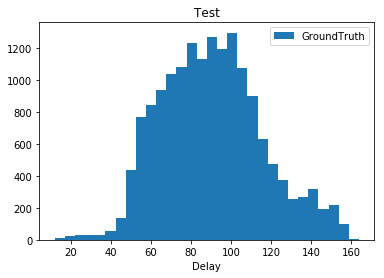

In [0]:
fig = plt.figure()
nbins = 30
plt.hist(dataSet[:, -1], nbins, label=['GroundTruth'])
plt.xlabel('Delay')
plt.legend(loc='upper right')
if training:
    plt.title('Training')
else:
    plt.title('Test')
plt.show()

## Learning and/or Prediction

In [0]:
# Shuffle the Dataset set
totSamples = np.shape(dataSet)[0]
order = np.argsort(np.random.random(totSamples))
dataSet = dataSet[order]

train_data = dataSet[:, :-1]
train_labels = dataSet[:, -1]
test_data = testdata[:, :-1]
test_labels = testdata[:, -1]

# Normalizing Features
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
samplePath_inp = (samplePath[:, :-1] - mean) / std
k = 0
train_err = []
val_err = []
for learning_rate in learning_rate_range:
    model_directory = directory + '/model'
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)

    if learning:
        model = build_model(learning_rate)
        # Training
        # The patience parameter is the amount of epochs to check for improvement
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        # Store training stats
        history = model.fit(train_data, train_labels, epochs=Epochs,
                            batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[PrintDot()])

        # serialize model to JSON

        model_json = model.to_json()
        name = "/model %s_%s (rho %3.2f).json" % (ArrivalType, ServiceType, rho)
        with open(model_directory + name, "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        name = "/weights %s_%s (rho %3.2f).h5" % (ArrivalType, ServiceType, rho)
        model.save_weights(model_directory + name)
        print("Saved model to disk")
        train_err = np.append(train_err, np.array(history.history['loss'])[-1])
        val_err = np.append(val_err, np.array(history.history['val_loss'])[-1])
        plot_history(history)
    else:
        # load json and create model
        name = "/model %s_%s (rho %3.2f).json" % (ArrivalType, ServiceType, rho)
        json_file = open(model_directory + name, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        name = "/weights %s_%s (rho %3.2f).h5" % (ArrivalType, ServiceType, rho)
        model.load_weights(model_directory + name)
        print("Loaded model from disk")
        # evaluate loaded model on test data
        model.compile(loss='mse',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['mae'])


Instructions for updating:
Colocations handled automatically by placer.
Loaded model from disk


## Plotting Groundtruth vs Predictions

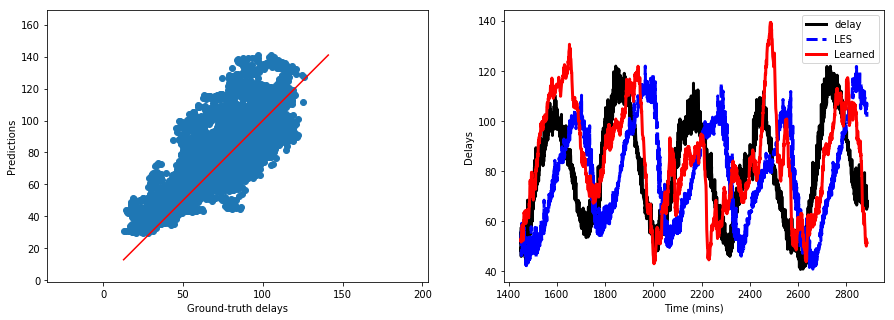

MSE: 256.1631, MSE_LES: 661.8593


In [0]:
# ----------------------Sampling from test_data for plotting---------------------------------
train_len = np.shape(train_data)[0]
test_len = np.shape(test_data)[0]
sampled_data = np.zeros((1, testdata.shape[1]))
# nbins = 10
# sampleNum = 100
# num_per_bin = int(sampleNum / nbins)
# bins = np.linspace(0, max(testdata[:, -1]), nbins + 1)
# for i in range(1, nbins + 1):
#     temp = np.arange(testdata.shape[0])[np.digitize(testdata[:, -1], bins) == i]
#     if len(temp) > 0:
#         choose = np.random.choice(temp, min(num_per_bin, len(temp)), replace=False)
#         sampled_data = np.append(sampled_data, testdata[choose, :], axis=0)
# plot_data = sampled_data[1:, :]
# plot_data_norm = (plot_data[:, :-1] - mean) / std
# sample_len = plot_data.shape[0]
# ///////////////////////////////////////////////////////////////////////////////////
# test_pred = model.predict(plot_data_norm)

# index_sorted_data = np.argsort(plot_data[:, -1])
# sorted_data = plot_data[:, wLES_ind][index_sorted_data]
# sorted_label = plot_data[index_sorted_data, -1]

nbins = 30
z_sim, x_sim, y_sim = np.histogram2d(dataSet[:, -1].flatten(), dataSet[:, -1].flatten(), nbins, normed='True')
# -----------Normalization for getting the conditional distribution------------
eps = 10**-15
z_sim = z_sim/(np.sum(z_sim, axis=0, keepdims=True)+eps)
# -----------calculating centers of the bins-----------
x_sim = (x_sim[:-1]+x_sim[1:])/2.0
y_sim = (y_sim[:-1]+y_sim[1:])/2.0
# -----------Making it ready for the meshplot-----------
x_sim = np.tile(x_sim.reshape(-1, 1), (1, nbins))
y_sim = np.tile(y_sim.reshape(1, -1), (nbins, 1))
# -------------------------------------------------------
if matlab_mode:
    x_sim_m = matlab.double(x_sim.tolist())
    y_sim_m = matlab.double(y_sim.tolist())
    z_sim_m = matlab.double(z_sim.tolist())
    h = eng.figure()
    eng.mesh(x_sim_m, y_sim_m, z_sim_m)
    eng.xlabel('delay')
    eng.ylabel('LES delay')
    eng.title('PDF (Simulated)')
# -----------SCATTER PLOT FOR PREDICTIOMNS-----------
test_pred = model.predict(test_data)
min_range, max_range = min(min(test_labels), min(test_pred)), max(max(test_labels), max(test_pred))
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(121)
plt.scatter(test_labels, test_pred)
plt.xlabel('Ground-truth delays')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim([-1, 1.2 * max_range])
plt.ylim([-1, 1.2 * max_range])
plt.plot([min_range, max_range], [min_range, max_range], 'r')
# ----------------------PLOTTING A SAMPLE PATH---------------------------------
samplePath_predictions = model.predict(samplePath_inp)

# fig = plt.figure()
plt.subplot(122)
plt.plot(Ta_samp, samplePath[:, -1], c='k', lw=3., label='delay')
plt.plot(Ta_samp, Tot_LCS_sample[:, 0], c='b', lw=3., ls='--', label='LES')
plt.plot(Ta_samp, samplePath_predictions, c='r', lw=3., label='Learned')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Delays')
plt.show()
# ----------------------Comparing the efficiency of LES and RNN model-----------
MSE = mean_squared_error(test_labels, test_pred)
MSE_LES = mean_squared_error(test_labels, Tot_LCS_test[:, 0])
print("MSE: %7.4f, MSE_LES: %7.4f" %(MSE, MSE_LES))

# End-to-End Delay Prediction for Tandem Queues (RNN)


## Defining Neural Net Model

In [0]:
def build_RNN_model(hidden_units, seq_len, feature_num):
    HIDDEN_UNITS = hidden_units
    SEQ_LEN = seq_len
    FEATURE_NUM = feature_num
    model = keras.Sequential()
    model.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(None, SEQ_LEN, FEATURE_NUM), return_sequences=True))
    model.add(keras.layers.LSTM(HIDDEN_UNITS))
    model.add(keras.layers.Dense(1, activation=tf.nn.relu))
    model.compile(loss='mse', optimizer=keras.optimizers.Adam())
    model.summary()
    return model

class PrintDot(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

## Initialization

In [0]:
learning = 0  # set to one(zero) for learning (prediction)
ArrivalType = 'NonHomPoisson'
ServiceType = 'logNorm'
future_step = 1
hidden_units = 64
batch_size = 256
Epochs = 100

# matlab_mode = (learning == 0)
# if matlab_mode == 1:
#     import matlab.engine
#     eng = matlab.engine.start_matlab()

directory = gdrive_dir + '/MultiStage/Queueing_RNN_pred/%s_%s/stepsAhead %d' % (ArrivalType, ServiceType, future_step)
if not os.path.exists(directory):
    os.makedirs(directory)

## Learning and/or Prediction


In [0]:
k = 0
train_err = []
val_err = []
for learning_rate in learning_rate_range:
    model_directory = directory + '/model'
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)

    if learning:
        model_RNN = build_RNN_model(hidden_units, delayHistLength, feature_num)
        # Training
        # The patience parameter is the amount of epochs to check for improvement
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        # Store training stats
        history = model_RNN.fit(train_data.reshape(-1, delayHistLength, feature_num), train_labels, epochs=Epochs,
                            batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[PrintDot()])

        # serialize model to JSON

        model_json = model_RNN.to_json()
        name = "/model %s_%s (rho %3.2f).json" % (ArrivalType, ServiceType, rho)
        with open(model_directory + name, "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        name = "/weights %s_%s (rho %3.2f).h5" % (ArrivalType, ServiceType, rho)
        model_RNN.save_weights(model_directory + name)
        print("Saved model to disk")
        train_err = np.append(train_err, np.array(history.history['loss'])[-1])
        val_err = np.append(val_err, np.array(history.history['val_loss'])[-1])
        plot_history(history)
    else:
        # load json and create model
        name = "/model %s_%s (rho %3.2f).json" % (ArrivalType, ServiceType, rho)
        json_file = open(model_directory + name, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model_RNN = model_from_json(loaded_model_json)
        # load weights into new model
        name = "/weights %s_%s (rho %3.2f).h5" % (ArrivalType, ServiceType, rho)
        model_RNN.load_weights(model_directory + name)
        print("Loaded model from disk")
        # evaluate loaded model on test data
        model_RNN.compile(loss='mse',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['mae'])


Loaded model from disk


## Plotting Ground-truth vs Predictions

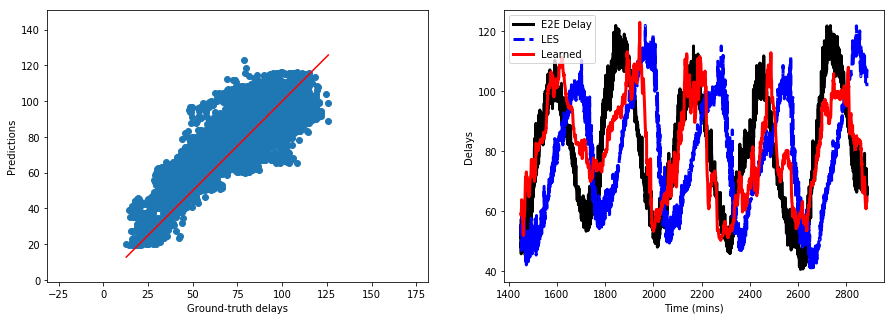

MSE_RNN: 183.1101, MSE_LES: 661.8593


In [0]:
# ----------------------Sampling from test_data for plotting---------------------------------
train_len = np.shape(train_data)[0]
test_len = np.shape(test_data)[0]
sampled_data = np.zeros((1, testdata.shape[1]))
nbins = 30
z_sim, x_sim, y_sim = np.histogram2d(dataSet[:, -1].flatten(), dataSet[:, -1].flatten(), nbins, normed='True')
# -----------Normalization for getting the conditional distribution------------
eps = 10**-15
z_sim = z_sim/(np.sum(z_sim, axis=0, keepdims=True)+eps)
# -----------calculating centers of the bins-----------
x_sim = (x_sim[:-1]+x_sim[1:])/2.0
y_sim = (y_sim[:-1]+y_sim[1:])/2.0
# -----------Making it ready for the meshplot-----------
x_sim = np.tile(x_sim.reshape(-1, 1), (1, nbins))
y_sim = np.tile(y_sim.reshape(1, -1), (nbins, 1))
# -------------------------------------------------------
if matlab_mode:
    x_sim_m = matlab.double(x_sim.tolist())
    y_sim_m = matlab.double(y_sim.tolist())
    z_sim_m = matlab.double(z_sim.tolist())
    h = eng.figure()
    eng.mesh(x_sim_m, y_sim_m, z_sim_m)
    eng.xlabel('delay')
    eng.ylabel('LES delay')
    eng.title('PDF (Simulated)')
# -----------SCATTER PLOT FOR PREDICTIOMNS-----------
test_pred = model_RNN.predict(test_data.reshape(-1, delayHistLength, feature_num))
min_range, max_range = min(min(test_labels), min(test_pred)), max(max(test_labels), max(test_pred))
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(121)
plt.scatter(test_labels, test_pred)
plt.xlabel('Ground-truth delays')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim([-1, 1.2 * max_range])
plt.ylim([-1, 1.2 * max_range])
plt.plot([min_range, max_range], [min_range, max_range], 'r')
# ----------------------PLOTTING A SAMPLE PATH---------------------------------
samplePath_predictions = model_RNN.predict(samplePath_inp.reshape(-1, delayHistLength, feature_num))

plt.subplot(122)
plt.plot(Ta_samp, samplePath[:, -1], c='k', lw=3., label='E2E Delay')
plt.plot(Ta_samp, Tot_LCS_sample[:, 0], c='b', lw=3., ls='--', label='LES')
plt.plot(Ta_samp, samplePath_predictions, c='r', lw=3., label='Learned')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Delays')
plt.show()
# ----------------------Comparing the efficiency of LES and RNN model-----------
MSE_RNN = mean_squared_error(test_labels, test_pred)
MSE_LES = mean_squared_error(test_labels, Tot_LCS_test[:, 0])
print("MSE_RNN: %7.4f, MSE_LES: %7.4f" %(MSE_RNN, MSE_LES))

# Predicting End-to- End Delay Distribution in Tandem Queues (RNN-MDN)


## Defining Neural Net Model

In [0]:
def build_RNN_MDN_model(output_dim, num_mixes, hidden_units, seq_len, feature_num):
    OUTPUT_DIMENSION = output_dim
    NUMBER_MIXTURES = num_mixes
    HIDDEN_UNITS = hidden_units
    SEQ_LEN = seq_len
    FEATURE_NUM = feature_num
    model = keras.Sequential()
    model.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(None, SEQ_LEN, FEATURE_NUM), return_sequences=True))
    model.add(keras.layers.LSTM(HIDDEN_UNITS))
    model.add(MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
    model.compile(loss=get_mixture_loss_func(OUTPUT_DIMENSION, NUMBER_MIXTURES), optimizer=keras.optimizers.Adam())
    model.summary()
    return model

## Initialization

In [0]:
learning = 0  # set to one(zero) for learning (prediction)
num_mixes_range = np.arange(2, 3)
hypParSet = []
for num_mixes in num_mixes_range:
        hypParSet.append(num_mixes)

future_step = 1
delayHistLength = 5
hidden_units = 64
output_dim = 1
batch_size = 256
Epochs = 100
# matlab_mode = (learning == 0)
# if matlab_mode == 1:
#     import matlab.engine
#     eng = matlab.engine.start_matlab()

directory = gdrive_dir + '/MultiStage/Queueing_RNN_MDN/%s_%s/stepsAhead %d' % (ArrivalType, ServiceType, future_step)
if not os.path.exists(directory):
    os.makedirs(directory)


## Training and/or Prediction

Loaded model from disk


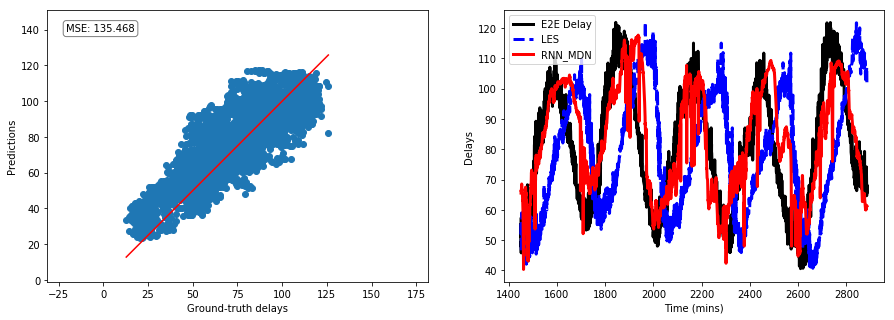

MSE_RNN_MDN: 135.4683, MSE_LES: 661.8593


In [0]:
k = 0
train_err = []
val_err = []
for hyp in hypParSet:
    num_mixes = hyp
    model_directory = directory + '/model/num_mixes_%d' % num_mixes
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)

    if learning:
        model_RNN_MDN = build_RNN_MDN_model(output_dim, num_mixes, hidden_units, delayHistLength, feature_num)
        # Training
        # The patience parameter is the amount of epochs to check for improvement
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        # Store training stats
        history = model_RNN_MDN.fit(train_data.reshape(-1, delayHistLength, feature_num), train_labels, epochs=Epochs,
                            batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[PrintDot()])

        # serialize model to JSON

        model_json = model_RNN_MDN.to_json()
        name = "/model %s_%s (rho %3.2f_numMixes %d).json" % (ArrivalType, ServiceType, rho, num_mixes)
        with open(model_directory + name, "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        name = "/weights %s_%s (rho %3.2f_numMixes %d).h5" % (ArrivalType, ServiceType, rho, num_mixes)
        model_RNN_MDN.save_weights(model_directory + name)
        print("Saved model to disk")
        train_err = np.append(train_err, np.array(history.history['loss'])[-1])
        val_err = np.append(val_err, np.array(history.history['val_loss'])[-1])
        plot_history(history)
    else:
        # load json and create model
        name = "/model %s_%s (rho %3.2f_numMixes %d).json" % (ArrivalType, ServiceType, rho, num_mixes)
        json_file = open(model_directory + name, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model_RNN_MDN = model_from_json(loaded_model_json, custom_objects={'MDN': MDN})
        # load weights into new model
        name = "/weights %s_%s (rho %3.2f_numMixes %d).h5" % (ArrivalType, ServiceType, rho, num_mixes)
        model_RNN_MDN.load_weights(model_directory + name)
        print("Loaded model from disk")
        # evaluate loaded model on test data
        model_RNN_MDN.compile(loss=get_mixture_loss_func(output_dim, num_mixes),
                      optimizer=keras.optimizers.Adam())

#   -------------------Sampling from test_data for plotting------------------------------------
    train_len = np.shape(train_data)[0]
    test_len = np.shape(test_data)[0]
    sampled_data = np.zeros((1, testdata.shape[1]))
    nbins = 10
    sampleNum = 100
    num_per_bin = int(sampleNum / nbins)
    bins = np.linspace(0, max(testdata[:, -2]), nbins + 1)
    for i in range(1, nbins + 1):
        temp = np.arange(testdata.shape[0])[np.digitize(testdata[:, -2], bins) == i]
        if len(temp) > 0:
            choose = np.random.choice(temp, min(num_per_bin, len(temp)), replace=False)
            sampled_data = np.append(sampled_data, testdata[choose, :], axis=0)
    plot_data = sampled_data[1:, :]
    plot_data_norm = (plot_data[:, :-1] - mean) / std
    sample_len = plot_data.shape[0]
#   ------------------------------------------------------------------------------------------
    test_pred = model_RNN_MDN.predict(plot_data_norm.reshape(-1, delayHistLength, feature_num))
    mus = test_pred[:, :num_mixes * output_dim]
    sigs = test_pred[:, num_mixes * output_dim:2 * num_mixes * output_dim]
    pis = softmax(test_pred[:, -num_mixes:])
    predictions = np.sum(mus*pis, axis=1)

    index_sorted_data = np.argsort(plot_data[:, -2])
    sorted_data = plot_data[:, -2][index_sorted_data]
    sorted_label = plot_data[index_sorted_data, -1]
    mus = mus[index_sorted_data]
    sigs = sigs[index_sorted_data]
    pis = pis[index_sorted_data]
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    # nbins = test_data.shape[0]
    nbins = 100
    y = np.tile(sorted_data.reshape(1, -1), (nbins, 1))
    xi = np.linspace(0.5 * plot_data[:, -1].min(), 1.2 * plot_data[:, -1].max(), nbins)
    x = np.tile(xi.reshape(-1, 1), (1, y.shape[1]))
    z = np.zeros(x.shape)
    for j in range(x.shape[1]):
        for i in range(num_mixes):
            z[:, j] = z[:, j] + pis[j, i] * norm.pdf(xi, mus[j, i], sigs[j, i])

    if matlab_mode:
        xm = matlab.double(x.tolist())
        ym = matlab.double(y.tolist())
        zm = matlab.double(z.tolist())
        np.random.seed(20)
        colors = np.random.uniform(0, 1, (sample_len, 3))
        h = eng.figure()
        eng.hold("on", nargout=0)
        for k in range(sample_len):
            eng.line(matlab.double(x[:, k].tolist()), matlab.double(y[:, k].tolist()), matlab.double(z[:, k].tolist()),
                     'color', matlab.double(colors[k].tolist()))
            eng.view(3)

        eng.scatter3(matlab.double(sorted_label.tolist()), matlab.double(sorted_data.tolist()),
                     matlab.double(np.zeros(sample_len).tolist()), matlab.double([]), matlab.double(colors.tolist()))
        eng.xlabel('delay')
        eng.ylabel('LES delay')
        eng.title('trained PDF (test data, Num of mix:%d)' % num_mixes)
        fig_path = fig_directory + '/PDF(trained) %s_%s (rho %3.2f_numMixes %d).fig' % (
        ArrivalType, ServiceType, rho, num_mixes)
        eng.savefig(fig_path, nargout=0)

    if matlab_mode and len(num_mixes_range) > 1:
        nr = matlab.double(num_mixes_range.tolist())
        te = matlab.double(train_err.tolist())
        ve = matlab.double(val_err.tolist())
        h = eng.figure()
        eng.plot(nr, te, 'b', nr, ve, 'r')
        eng.legend('Training', 'Validation')
        eng.xlabel('Number of mixtures')
        eng.ylabel('Error')
        fig_path = fig_directory + '/ErrorVsNumMixes %s_%s (rho %3.2f).fig' % (ArrivalType, ServiceType, rho)
        eng.savefig(fig_path, nargout=0)

    nbins = 30

    z_sim, x_sim, y_sim = np.histogram2d(dataSet[:, -1].flatten(), dataSet[:, -2].flatten(), nbins, normed='True')
#     ------------------Normalization for getting the conditional distribution--------------------------
    eps = 10**-15
    z_sim = z_sim/(np.sum(z_sim, axis=0, keepdims=True)+eps)
#     ------------------calculating centers of the bins-------------------------------------------------
    x_sim = (x_sim[:-1]+x_sim[1:])/2.0
    y_sim = (y_sim[:-1]+y_sim[1:])/2.0
#     ------------------Making it ready for the meshplot------------------------------------------------
    x_sim = np.tile(x_sim.reshape(-1, 1), (1, nbins))
    y_sim = np.tile(y_sim.reshape(1, -1), (nbins, 1))
#     --------------------------------------------------------------------------------------------------
    if matlab_mode:
        x_sim_m = matlab.double(x_sim.tolist())
        y_sim_m = matlab.double(y_sim.tolist())
        z_sim_m = matlab.double(z_sim.tolist())
        h = eng.figure()
        eng.mesh(x_sim_m, y_sim_m, z_sim_m)
        eng.xlabel('delay')
        eng.ylabel('LES delay')
        eng.title('PDF (Simulated)')
        fig_path = fig_directory + '/PDF(Simulated) %s_%s (rho %3.2f_numMixes %d).fig' % (ArrivalType, ServiceType, rho, num_mixes)
        eng.savefig(fig_path, nargout=0)
#     ---------------------------SCATTER PLOT FOR PREDICTIOMNS---------------------------------------------
    test_pred = model_RNN_MDN.predict(test_data.reshape(-1, delayHistLength, feature_num))
    mus = test_pred[:, :num_mixes * output_dim]
    sigs = test_pred[:, num_mixes * output_dim:2 * num_mixes * output_dim]
    pis = softmax(test_pred[:, -num_mixes:])
    predictions = np.sum(mus * pis, axis=1)

    min_range, max_range = min(min(test_labels), min(predictions)), max(max(test_labels), max(predictions))
    fig = plt.figure(figsize=(15,5))
    ax = plt.subplot(121)
    plt.scatter(test_labels, predictions)
    plt.xlabel('Ground-truth delays')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.xlim([-1, 1.2 * max_range])
    plt.ylim([-1, 1.2 * max_range])
    plt.plot([min_range, max_range], [min_range, max_range], 'r')
    mse = mean_squared_error(test_labels, predictions)
    props = dict(boxstyle='round', facecolor='White', alpha=0.5)
    textstr = 'MSE: %.3f' % mse
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
#     ------------------------------------PLOTTING A SAMPLE PATH---------------------------------------------
    samplePath_pred_params = model_RNN_MDN.predict(samplePath_inp.reshape(-1, delayHistLength, feature_num))
    mus = samplePath_pred_params[:, :num_mixes * output_dim]
    sigs = samplePath_pred_params[:, num_mixes * output_dim:2 * num_mixes * output_dim]
    pis = softmax(samplePath_pred_params[:, -num_mixes:])
    samplePath_predictions = np.sum(mus * pis, axis=1)

    plt.subplot(122)
    plt.plot(Ta_samp, samplePath[:, -1], c='k', lw=3., label='E2E Delay')
    plt.plot(Ta_samp,  Tot_LCS_sample[:, 0], c='b', lw=3., ls='--', label='LES')
    plt.plot(Ta_samp, samplePath_predictions, c='r', lw=3., label='RNN_MDN')
    plt.legend()
    plt.xlabel('Time (mins)')
    plt.ylabel('Delays')
    plt.show()
#     ------------------------------------Comparing the efficiency of LES and RNN_MDN model-------------------------
    MSE_LES = mean_squared_error(test_labels, Tot_LCS_test[:, 0])
    MSE_RNN_MDN = mean_squared_error(test_labels, predictions)
    print("MSE_RNN_MDN: %7.4f, MSE_LES: %7.4f" %(MSE_RNN_MDN, MSE_LES))

## Predicting Upperbound and Lowerbounds for the E2E Delay

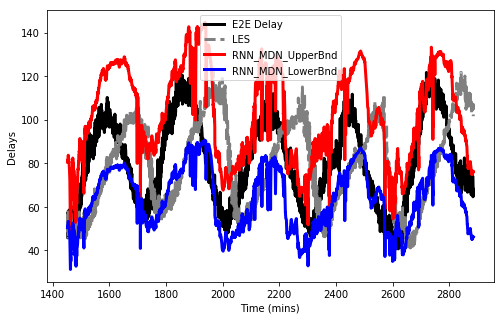

In [0]:
from scipy.optimize import fsolve
P_ub = 0.9
P_lb = 0.9
samplePath_upperBnd = []
samplePath_lowerBnd = []
#     ------------------------------------PLOTTING BOUNDS FOR A SAMPLE PATH---------------------------------------------
samplePath_pred_params = model_RNN_MDN.predict(samplePath_inp.reshape(-1, delayHistLength, feature_num))
for i in range(np.shape(samplePath_pred_params)[0]):
  mixCDF_ub = lambda x: mixture_CDF(x, samplePath_pred_params[i:i+1], output_dim, num_mixes) - P_ub
  mixCDF_lb = lambda x: 1 - mixture_CDF(x, samplePath_pred_params[i:i+1], output_dim, num_mixes) - P_lb
  samplePath_upperBnd.append(fsolve(mixCDF_ub, 0.01))
  samplePath_lowerBnd.append(fsolve(mixCDF_lb, 0.01))


fig = plt.figure(figsize=(8,5))
plt.plot(Ta_samp, samplePath[:, -1], c='k', lw=3., label='E2E Delay')
plt.plot(Ta_samp, Tot_LCS_sample[:, 0], c='0.5', lw=3., ls='--', label='LES')
plt.plot(Ta_samp, samplePath_upperBnd, c='r', lw=3., label='RNN_MDN_UpperBnd')
plt.plot(Ta_samp, samplePath_lowerBnd, c='b', lw=3., label='RNN_MDN_LowerBnd')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Delays')
plt.show()
